# Gathering excerpts of raw recordings to show snapshots 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al
%aimport respy

In [3]:
%reload_ext autoreload

# Load data

In [4]:
Piece_timings = pd.read_csv('./Timing/Concerttimes_Seconds.csv')
PartDets = pd.read_csv('../Data/Participant_Metadata_stage.csv',index_col=0)
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC703','PC701','PC702','PC708','PC707','PC706']
print(len(player_order))
Dets=PartDets.loc[player_order,['Section', 'Instrument', 'Stage_X', 'Stage_Y']].copy()

57


In [5]:
concert_loc = {
    'RD':'../Data/AlignedPhys/20230215_RD/Full/',
    'C1':'../Data/AlignedPhys/20230216_C1/Full/',
    'C2':'../Data/AlignedPhys/20230216_C2/Full/',
    'C3':'../Data/AlignedPhys/20230217_C3/Full/',
    'C4':'../Data/AlignedPhys/20230217_C4/Full/',
    'C5':'../Data/AlignedPhys/20230218_C5/Full/'}

concerts = list(concert_loc.keys())

In [6]:
datafile_type = 'CIBI' # EQCIBI and MSCIBI
piece = 'Full'
concert = 'C3'
data_loc = concert_loc[concert]

# first find data for each participant for that concert
sig_folders = {}
for c in concerts:
    data_loc = concert_loc[c]
    files = os.listdir(data_loc)
    files.sort()
    sig_files = {}
    for f in files: 
        if f.endswith(datafile_type+'.csv'): 
            partID = f.split('_')[2]
            sig_files[partID] = data_loc+f
    sig_folders[c] = sig_files.copy()

In [7]:
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC703','PC701','PC702','PC708','PC707','PC706']

In [14]:
mydpi = 192

In [24]:
buff = 5
projectPath = '../Data/Cardiac/C5/'
# Interval to keep 
t1 = pd.to_datetime('2023-02-18 15:00:03.283000+00:00')# 17:15:00 + 0100  less 15 minutes
t2 = pd.to_datetime('2023-02-18 16:00:03.283000+00:00') # 18:39:13 + 0100 plus 15 minutes
#t2 = t1+pd.to_timedelta(240,'s')
[t1,t2]
eqfiles = os.listdir(projectPath)

seg_ts=[]
seg_ts.append(pd.to_datetime('2023-02-18 15:18:03.283000+00:00')+ pd.to_timedelta(30,unit='s'))
seg_ts.append(pd.to_datetime('2023-02-18 15:14:35.749000+00:00')- pd.to_timedelta(7,unit='s'))
seg_ts.append(pd.to_datetime('2023-02-18 15:14:35.749000+00:00')+pd.to_timedelta(2,unit='s'))
seg_i = 0
ts = seg_ts[seg_i]
te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s')
print([ts,te])

[Timestamp('2023-02-18 15:18:33.283000+0000', tz='UTC'), Timestamp('2023-02-18 15:18:38.283000+0000', tz='UTC')]


ECG-VN102-3420426-23021800-cut.csv
DATA-VN102-3420426-23021800-cut.csv
RR-VN102-3420426-23021800-cut.csv
RESPACC-VN102-3420426-23021800-cut.csv
FASTACC-VN102-3420426-23021800-cut.csv


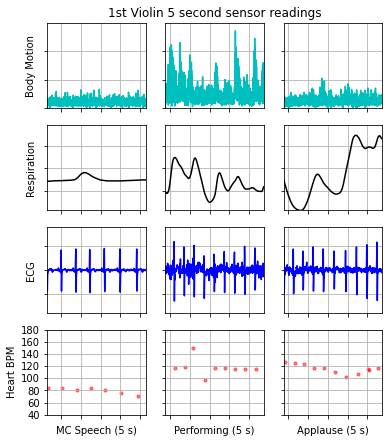

In [26]:
# for partID in player_order[22:]:
partID = 'VN102'
fig, (axs) = plt.subplots(4, 3, figsize = [6,8])
for file in eqfiles:
    if partID in file: 
        print(file)
        if file.startswith('FASTACC'):
            smin = 100
            smax = 100
            for seg_i in range(len(seg_ts)):
                ts = seg_ts[seg_i]
                te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s')
                ax=axs[0,seg_i]
                V = qex.cut_by_time(projectPath + file,ts,te) #V = pd.read_csv(projectPath +file)
                V['Jerk'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
                V['Jerk'].plot(color='c',ax=ax)
                ax.set_xlim([ts,te])
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.grid()
                ax.set_xlabel('')
                if V['Jerk'].min()<smin: smin = V['Jerk'].min()
                if V['Jerk'].max()>smax: smax = V['Jerk'].max()
            smax = 1.1*smax
            axs[0,0].set_ylim([smin,smax])
            axs[0,1].set_ylim([smin,smax])
            axs[0,2].set_ylim([smin,smax])
            axs[0,0].set_ylabel('Body Motion')
        if file.startswith('RESPACC'):
            smin = 500
            smax = 500
            for seg_i in range(len(seg_ts)):
                ts = seg_ts[seg_i]
                te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s')
                ax=axs[1,seg_i]
                V = qex.cut_by_time(projectPath + file,ts,te) #V = pd.read_csv(projectPath + file)
                V['Breathing'].plot(color='k',ax=ax)
                ax.set_xticklabels([])
                ax.set_xlim([ts,te])
                ax.set_yticklabels([])
                ax.grid()
                ax.set_xlabel('')
                if V['Breathing'].min()<smin: smin = V['Breathing'].min()
                if V['Breathing'].max()>smax: smax = V['Breathing'].max()
            smax = 1.1*smax
            axs[1,0].set_ylim([smin,smax])
            axs[1,1].set_ylim([smin,smax])
            axs[1,2].set_ylim([smin,smax])
            axs[1,0].set_ylabel('Respiration')
        if file.startswith('ECG'):
            smax = 0.5
            for seg_i in range(len(seg_ts)):
                ts = seg_ts[seg_i]
                te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s')
                ax=axs[2,seg_i]
                V = qex.cut_by_time(projectPath + file,ts,te) #V = pd.read_csv(projectPath + file)
                V['DateTime'] = V.index #pd.to_datetime(V.Index)      
                V['Lead 1'].plot(color='b',ax=ax)
                ax.set_xlim([ts,te])
                ax.set_xticklabels([])
                ax.grid()
                ax.set_xlabel('')
                ax.set_yticklabels([])
                if V['Lead 1'].max()>smax: smax = V['Lead 1'].max()
            smax = 1.5*smax
            axs[2,0].set_ylim([-smax,smax])
            axs[2,1].set_ylim([-smax,smax])
            axs[2,2].set_ylim([-smax,smax])
            axs[2,0].set_ylabel('ECG')
        if file.startswith('RR'):
            for seg_i in range(len(seg_ts)):
                ts = seg_ts[seg_i]
                te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s')
                sf = 5
                ax=axs[3,seg_i]
                V = qex.cut_by_time(projectPath + file,ts,te)
    #             V = pd.read_csv(projectPath + file)

                if V is not None:
                    V['DateTime'] = V.index #pd.to_datetime(V.Index)
                    V = V.loc[V['Interbeat Interval (MS)']>200,:].reset_index(drop=True)
                    sig_t = (V['DateTime']-V['DateTime'][0]).dt.total_seconds()
                    sig_v = V['Interbeat Interval (MS)']
                    ax.scatter(x =V['DateTime'],y=(60000/V['Interbeat Interval (MS)']),s=10,color='r',alpha = 0.5,label='Single Beat')
                ax.set_yticks([40,60,80,100,120,140,160,180])
                ax.set_yticklabels([])
                ax.set_ylim([40,180])
                ax.set_xlim([ts,te])
                ax.set_xticklabels([])
                ax.set_xlabel('')
                ax.grid()
            axs[3,0].set_yticklabels([40,60,80,100,120,140,160,180])
            axs[3,0].set_ylabel('Heart BPM')
axs[0,1].set_title(' '.join([PartDets.loc[partID,'Instrument'],str(buff),'second sensor readings']))
axs[3,0].set_xlabel('MC Speech (5 s)')
axs[3,1].set_xlabel('Performing (5 s)')
axs[3,2].set_xlabel('Applause (5 s)')
plt.savefig('./plots/Web/'+ partID+ '_5s_samples.png',bbox_inches = 'tight',dpi=mydpi)
# plt.savefig('../Summaries/Plots/short_cuts/'+ partID+ '_5s_samples.png',bbox_inches = 'tight',dpi=mydpi)
# plt.close()
plt.show()

In [723]:
msfiles = os.listdir(projectPath)
msfiles.sort()

msfiles

['.DS_Store',
 'ECG-PC706-537-230217075913.csv',
 'ECG-PC706-577-230215105831.csv',
 'ECG-PC706-587-230216074249.csv',
 'ECG-PC708-510-230218141121.csv',
 'ECG-PC708-596-230216075246.csv',
 'ECG-PC708-596-230216093335.csv',
 'ECG-PC708-620-230217074533.csv',
 'ECG-PC708-620-230217092559.csv',
 'FASTACC-PC706-537-230217075913.csv',
 'FASTACC-PC706-577-230215105831.csv',
 'FASTACC-PC706-587-230216074249.csv',
 'FASTACC-PC708-510-230218141120.csv',
 'FASTACC-PC708-596-230216075246.csv',
 'FASTACC-PC708-596-230216093334.csv',
 'FASTACC-PC708-620-230217074533.csv',
 'FASTACC-PC708-620-230217092559.csv',
 'RR-PC706-537-230217075913.csv',
 'RR-PC706-577-230215105831.csv',
 'RR-PC706-587-230216074249.csv',
 'RR-PC708-510-230218141121.csv',
 'RR-PC708-596-230216075246.csv',
 'RR-PC708-596-230216093335.csv',
 'RR-PC708-620-230217074533.csv',
 'RR-PC708-620-230217092559.csv']

[Timestamp('2023-02-17 10:32:47.697000+0000', tz='UTC'), Timestamp('2023-02-17 10:32:52.697000+0000', tz='UTC')]


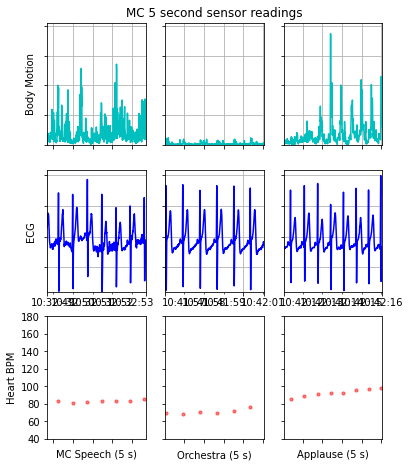

Recording does not intersect with that time interval
Recording does not intersect with that time interval
Recording does not intersect with that time interval
Recording does not intersect with that time interval
Recording does not intersect with that time interval
Recording does not intersect with that time interval
Recording does not intersect with that time interval
Recording does not intersect with that time interval
Recording does not intersect with that time interval


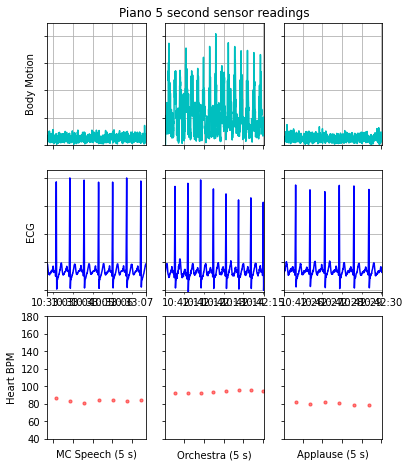

In [20]:
buff = 5 # 2 minutes? 5 seconds
projectPath = '../Data/Movesense/EqForm_new/'
msfiles = os.listdir(projectPath)
msfiles.sort()

seg_ts = []



# seg_ts.append(pd.to_datetime('2023-02-16 09:05:40.356000+00:00')+ pd.to_timedelta(30,unit='s'))
# seg_ts.append(pd.to_datetime('2023-02-16 09:12:51.604000+00:00')- pd.to_timedelta(25,unit='s'))
# seg_ts.append(pd.to_datetime('2023-02-16 09:12:51.604000+00:00')+pd.to_timedelta(2,unit='s'))
seg_ts.append(pd.to_datetime('2023-02-17 10:29:27.697000+00:00')+ pd.to_timedelta(200,unit='s'))
seg_ts.append(pd.to_datetime('2023-02-17 10:42:05.035000+00:00')- pd.to_timedelta(10,unit='s'))
seg_ts.append(pd.to_datetime('2023-02-17 10:42:05.035000+00:00')+pd.to_timedelta(5,unit='s'))

# seg_ts.append(pd.to_datetime('2023-02-18 15:42:27.403000+00:00')+ pd.to_timedelta(30,unit='s'))
# seg_ts.append(pd.to_datetime('2023-02-18 15:48:23.563000+00:00')- pd.to_timedelta(25,unit='s'))
# seg_ts.append(pd.to_datetime('2023-02-18 15:48:23.563000+00:00')+pd.to_timedelta(2,unit='s'))


seg_i = 0
ts = seg_ts[seg_i]
te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s')
print([ts,te])

for partID in ['PC706','PC708']:
    if partID == 'PC708':
        dtshift = pd.to_timedelta(15,unit='s')
    else:
        dtshift = pd.to_timedelta(1,unit='s')
        
    fig, (axs) = plt.subplots(3, 3, figsize = [6,8.5])
    for file in msfiles:
        if partID in file: 
            if '-230217' in file:
                if file.startswith('FASTACC'):
                    smin = 0.5
                    smax = 0.5
                    for seg_i in range(len(seg_ts)):
                        ts = seg_ts[seg_i] +dtshift
                        te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s') +dtshift
                        ax=axs[0,seg_i]
                        V = qex.cut_by_time(projectPath + file,ts,te) #V = pd.read_csv(projectPath +file)
                        if V is not None:
                            V['Jerk'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))
                            V['Jerk'].plot(color='c',ax=ax)
                            if V['Jerk'].min()<smin: smin = V['Jerk'].min()
                            if V['Jerk'].max()>smax: smax = V['Jerk'].max()
                        ax.set_xlim([ts,te])
                        ax.set_xticklabels([])
                        ax.set_yticklabels([])
                        ax.grid()
                        ax.set_xlabel('')
                    smax = 1.1*smax
                    axs[0,0].set_ylim([smin,smax])
                    axs[0,1].set_ylim([smin,smax])
                    axs[0,2].set_ylim([smin,smax])
                    axs[0,0].set_ylabel('Body Motion')
                if file.startswith('ECG'):
                    smax = 0.6
                    smin = 0.4
                    for seg_i in range(len(seg_ts)):
                        ts = seg_ts[seg_i] + dtshift
                        te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s') +dtshift
                        ax=axs[1,seg_i]
                        V = qex.cut_by_time(projectPath + file,ts,te) #V = pd.read_csv(projectPath + file)
                        if V is not None:
                            V['DateTime'] = V.index #pd.to_datetime(V.Index)      
                            V['Lead 1'].plot(color='b',ax=ax)
                            if V['Lead 1'].max()>smax: smax = V['Lead 1'].max()
                            if V['Lead 1'].min()<smin: smin = V['Lead 1'].min()
                        ax.set_xlim([ts,te])
                        ax.set_xticklabels([])
                        ax.set_yticklabels([])
                        ax.grid()
                        ax.set_xlabel('')
                    smax = 1.1*smax
                    axs[1,0].set_ylim([smin,smax])
                    axs[1,1].set_ylim([smin,smax])
                    axs[1,2].set_ylim([smin,smax])
                    axs[1,0].set_ylabel('ECG')
                if file.startswith('RR'):
                    for seg_i in range(len(seg_ts)):
                        ts = seg_ts[seg_i] +dtshift
                        te = seg_ts[seg_i]+pd.to_timedelta(buff,unit='s')+dtshift
                        sf = 5
                        ax=axs[2,seg_i]
                        V = qex.cut_by_time(projectPath + file,ts,te)
                        if V is not None:
                            V['DateTime'] = V.index #pd.to_datetime(V.Index)
                            V = V.loc[V['Interbeat Interval (MS)']>200,:].reset_index(drop=True)
                            sig_t = (V['DateTime']-V['DateTime'][0]).dt.total_seconds()
                            sig_v = V['Interbeat Interval (MS)']
                            ax.scatter(x =V['DateTime'],y=(60000/V['Interbeat Interval (MS)']),s=10,color='r',alpha = 0.5,label='Single Beat')
                        ax.set_yticks([40,60,80,100,120,140,160,180])
                        ax.set_yticklabels([])
                        ax.set_ylim([40,180])
                        ax.set_xlim([ts,te])
                        ax.set_xticklabels([])
                        ax.set_xlabel('')
                        
                    axs[2,0].set_yticklabels([40,60,80,100,120,140,160,180])
#                     axs[2,0].grid()
#                     axs[2,1].grid()
#                     axs[2,2].grid()
                    axs[2,0].set_ylabel('Heart BPM')
    axs[0,1].set_title(' '.join([PartDets.loc[partID,'Instrument'],str(buff),'second sensor readings']))
    axs[2,0].set_xlabel('MC Speech (5 s)')
    axs[2,1].set_xlabel('Orchestra (5 s)')
    axs[2,2].set_xlabel('Applause (5 s)')
    plt.savefig('./plots/short_cuts/'+ partID+ '_5s_samples.png',bbox_inches = 'tight',dpi=mydpi)
#     plt.savefig('../Summaries/Plots/short_cuts/'+ partID+ '_5s_samples.png',bbox_inches = 'tight',dpi=mydpi)

#     plt.close()
    plt.show()

In [710]:
partID

'VA306'